# Analyze game tree with position evaluation
## Import

In [1]:
# Game graph library
import igraph
import chess
import math


class Game():
    def __init__(self, game):
        self.game = game
 
    @property
    def moves_uci(self):
        res = []
        node = self.game
        while not node.is_end():
            node = node.next()
            res.append(node.uci())
        return res
    
    @property
    def moves_nodes(self):
        res = []
        node = self.game
        while not node.is_end():
            node = node.next()
            res.append(node)
        return res


class GamesGraph():
    def __init__(self):
        self.graph = igraph.Graph(directed=True)

    def add_move(self, start_fen, end_fen, uci):
        vs = self._ensure_vertex(start_fen)
        vt = self._ensure_vertex(end_fen)
        try:
            e = self.graph.es.find(_source=vs.index, _target=vt.index)
            e["count"] += 1
        except:
            e = self.graph.add_edge(vs, vt)
            e["uci"] = uci
            e["count"] = 1

    @property
    def start_node(self):
        return self.graph.vs.find(chess.STARTING_FEN)

    def _ensure_vertex(self, fen):
        try:
            return self.graph.vs.find(fen)
        except:
            v = self.graph.add_vertex(name=fen)
            v["fen"] = fen
            v["turn"] = chess.Board(fen).turn
            return v


def games_graph(games, max_moves):
    gr = GamesGraph()

    for game in games:
        start_fen = game.game.board().fen()
        for move in game.moves_nodes[:max_moves]:
            fen = move.board().fen()
            uci = move.uci()
            gr.add_move(start_fen, fen, uci)
            start_fen = fen

    return gr


def compute_edge_weights_uniform(vertex):
    all_count = vertex.degree(mode="out")
    for edge in vertex.out_edges():
        edge["prob"] = 1.0
        edge["weight"] = 0.0


def compute_edge_weights_counting(vertex):
    all_count = sum(map(lambda x: x["count"], vertex.out_edges()))
    for edge in vertex.out_edges():
        # Certainty doesn't exist... Let's put a 90% ceiling.
        prob = min(edge["count"] / all_count, 0.9)
        edge["prob"] = prob
        edge["weight"] = -math.log(prob)


def compute_graph_weights(graph, black_uniform=False, white_uniform=False):
    # Compute the graph weights such that:
    # * The distance is the inverse of the probability to go from source to destination.
    # * Summation of two weights is the same as multiplying the probability.
    #
    # count: ranges from 1 to max; max = sum(out_edges["count"]).
    # prob: count / max_count; [0; 1]
    # weigth: -log(prob); [0; +inf] ~ [very_likely; unlikely]
    for vertex in graph.graph.vs:
        if vertex["turn"] == chess.WHITE and white_uniform:
            compute_edge_weights_uniform(vertex)
        elif vertex["turn"] == chess.BLACK and black_uniform:
            compute_edge_weights_uniform(vertex)
        else:
            compute_edge_weights_counting(vertex)


In [2]:
import chess.pgn
import io
import json

with open('playerx-games.json') as f:
    data = json.load(f)

games = []
for game in data:
    pgn = io.StringIO(game)
    games.append(Game(chess.pgn.read_game(pgn)))

white_games = [g for g in games if g.game.headers["White"] == "playerx"]
black_games = [g for g in games if g.game.headers["Black"] == "playerx"]
len(games), len(white_games), len(black_games)

(542, 273, 269)

In [3]:
# Load the evaluations
import chess

def load_evals_json(path):
    with open(path) as f:
        evaljs = json.load(f)

    evals = {}
    for pos in evaljs:
        evals[pos["fen"]] = pos["eval"]
    # add the initial position
    evals[chess.STARTING_FEN] = {
        "type": "cp",
        "value": 0,
    }
    return evals

# Returns [-1;1]
def rating(ev, fen):
    val = ev["value"]
    if ev["type"] == "cp":
        # Clamp to -300, +300. Winning a piece is enough.
        val = max(-300, min(300, val))
        return val / 300.0
    if val > 0: return 1.0
    if val < 0: return -1.0
    # This is mate, but is it white or black?
    b = chess.Board(fen)
    return 1.0 if b.turn == chess.WHITE else -1.0

# Returns [0;1], where 0 is min advantage, 1 is max for black.
def rating_black(ev, fen):
    return -rating(ev, fen) * 0.5 + 0.5

# Returns [0;1], where 0 is min advantage, 1 is max for black.
def rating_white(ev, fen):
    return rating(ev, fen) * 0.5 + 0.5


def compute_rating(evals, rating_fn):
    for fen in evals.keys():
        ev = evals[fen]
        evals[fen]["rating"] = rating_fn(ev, fen)


def update_graph_rating(g, evals):
    for v in g.graph.vs:
        v["rating"] = evals[v["fen"]]["rating"]

In [4]:
import chess
from functools import reduce

class Line():
    def __init__(self, end_node, moves, cost):
        self.end_node = end_node
        self.moves = moves
        self.cost = cost
    
    @property
    def moves_uci(self):
        return [e["uci"] for e in self.moves]
    
    @property
    def rating(self):
        return self.end_node["rating"]
    
    @property
    def probability(self):
        return reduce(lambda x, y: x*y, [e["prob"] for e in self.moves])
    
    @property
    def end_board(self):
        return chess.Board(self.end_node["fen"])

    @property
    def end_fen(self):
        return self.end_node["fen"]

    def __str__(self):
        return "{}: {} (prob={} rating={})".format(
            self.end_node["fen"],
            self.moves_uci,
            self.probability,
            self.rating,
        )
    
    def __repr__(self):
        return self.__str__()


def compute_line(graph, path):
    # Skip empty paths.
    if len(path) < 2:
        return None
    end_node = graph.graph.vs.find(path[-1])
    cost = 0
    moves = []
    for i in range(len(path) - 1):
        edge = graph.graph.es.find(_source=path[i], _target=path[i+1])
        cost += edge["weight"]
        moves.append(edge)
    return Line(end_node, moves, cost)


def best_lines(lines, min_rating=0.5):
    lines = filter(lambda x: x is not None, lines)
    return [
        l for l in sorted(lines, key=lambda x: x.cost)
        if l.rating > min_rating
    ]

## Graph test

a:  igraph.Vertex(<igraph.Graph object at 0x7f5e6dd3cb80>, 0, {'name': 'a'}) b:  igraph.Vertex(<igraph.Graph object at 0x7f5e6dd3cb80>, 1, {'name': 'b'})
0
edge 0, 1:  True


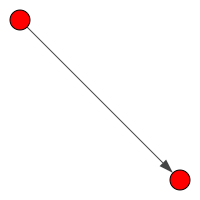

In [5]:
import igraph

g = igraph.Graph(directed=True)
g.add_vertex(name="a")
g.add_vertex(name="b")

a = g.vs.find("a")
b = g.vs.find("b")
print("a: ", a, "b: ", b)
print(a.index)

g.add_edge(a, b, name="foo")

print("edge 0, 1: ", g.es.find(_source=a.index, _target=b.index) != None)

igraph.plot(g, bbox=(200, 200))

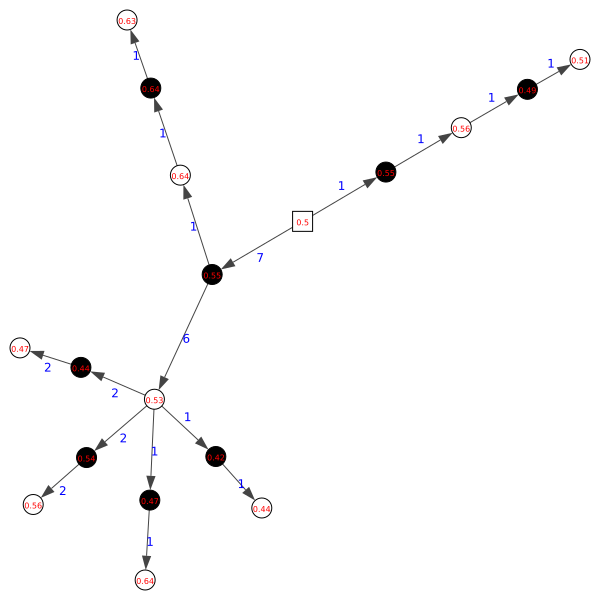

In [6]:
import igraph
import chess

g = games_graph(black_games[:8], 4)
fen_evals = load_evals_json('eval-black.json')
compute_rating(fen_evals, rating_white)
update_graph_rating(g, fen_evals)

style = {
    "edge_label": g.graph.es["count"],
    "edge_label_color": "blue",
    "vertex_label": ["{:.2}".format(x) for x in g.graph.vs["rating"]],
    "vertex_label_size": 8,
    "vertex_label_color": "red",
    "vertex_color": [("white" if x == chess.WHITE else "black") for x in g.graph.vs["turn"]],
    "vertex_shape": ["rectangle"] + ["circle" for _ in g.graph.vs][1:]
}
igraph.plot(g.graph, **style)

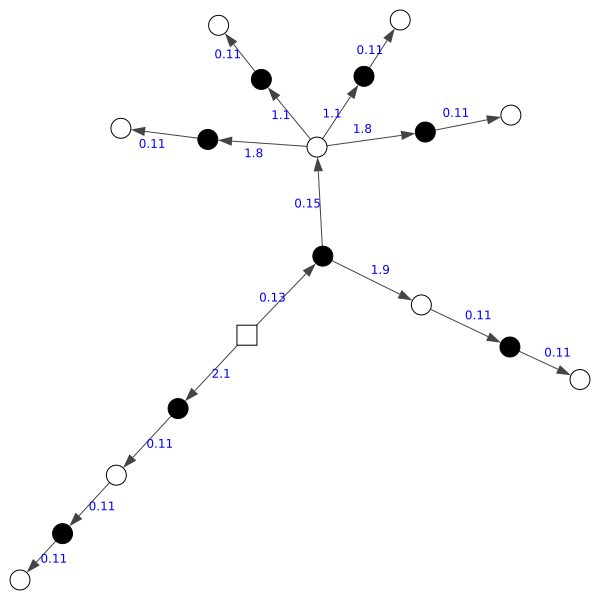

In [7]:
# Test weights without correcting for my moves equal probability.
compute_graph_weights(g)

style = {
    "edge_label": ["{:.2}".format(x) for x in g.graph.es["weight"]],
    "edge_label_color": "blue",
    "vertex_color": [("white" if x == chess.WHITE else "black") for x in g.graph.vs["turn"]],
    "vertex_shape": ["rectangle"] + ["circle" for _ in g.graph.vs][1:]
}
igraph.plot(g.graph, **style)

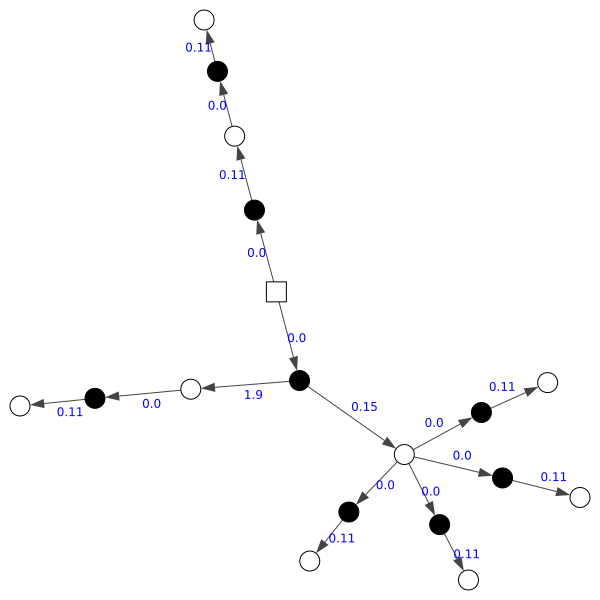

In [8]:
# Test the weights.
compute_graph_weights(g, white_uniform=True)

style = {
    "edge_label": ["{:.2}".format(x) for x in g.graph.es["weight"]],
    "edge_label_color": "blue",
    "vertex_color": [("white" if x == chess.WHITE else "black") for x in g.graph.vs["turn"]],
    "vertex_shape": ["rectangle"] + ["circle" for _ in g.graph.vs][1:]
}
igraph.plot(g.graph, **style)

In [9]:
# Shortest paths from initial to every other position.
sp = g.graph.get_shortest_paths(g.start_node, weights=g.graph.es["weight"])
sp

[[0],
 [0, 1],
 [0, 1, 2],
 [0, 1, 2, 3],
 [0, 1, 2, 3, 4],
 [0, 1, 5],
 [0, 1, 5, 6],
 [0, 1, 5, 6, 7],
 [0, 8],
 [0, 8, 9],
 [0, 8, 9, 10],
 [0, 8, 9, 10, 11],
 [0, 1, 2, 12],
 [0, 1, 2, 12, 13],
 [0, 1, 2, 14],
 [0, 1, 2, 14, 15],
 [0, 1, 2, 16],
 [0, 1, 2, 16, 17]]

In [10]:
lines = [compute_line(g, p) for p in sp]
lines = best_lines(lines)
lines

[rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR b KQkq - 0 1: ['e2e4'] (prob=1.0 rating=0.5466666666666666),
 rnbqkbnr/pppppppp/8/8/3P4/8/PPP1PPPP/RNBQKBNR b KQkq - 0 1: ['d2d4'] (prob=1.0 rating=0.5533333333333333),
 rnbqkbnr/ppp1pppp/8/3p4/3P4/8/PPP1PPPP/RNBQKBNR w KQkq - 0 2: ['d2d4', 'd7d5'] (prob=0.9 rating=0.5583333333333333),
 rnbqkbnr/pppp1ppp/8/4p3/4P3/8/PPPP1PPP/RNBQKBNR w KQkq - 0 2: ['e2e4', 'e7e5'] (prob=0.8571428571428571 rating=0.53),
 rnbqkbnr/pppp1ppp/8/4p3/4P3/5N2/PPPP1PPP/RNBQKB1R b KQkq - 1 2: ['e2e4', 'e7e5', 'g1f3'] (prob=0.8571428571428571 rating=0.5416666666666666),
 rnbqkb1r/ppp1pppp/5n2/3p4/3P4/2N5/PPP1PPPP/R1BQKBNR w KQkq - 2 3: ['d2d4', 'd7d5', 'b1c3', 'g8f6'] (prob=0.81 rating=0.5066666666666667),
 r1bqkbnr/pppp1ppp/2n5/4p3/3PP3/8/PPP2PPP/RNBQKBNR w KQkq - 1 3: ['e2e4', 'e7e5', 'd2d4', 'b8c6'] (prob=0.7714285714285714 rating=0.6383333333333333),
 r1bqkbnr/pppp1ppp/2n5/4p3/4P3/5N2/PPPP1PPP/RNBQKB1R w KQkq - 2 3: ['e2e4', 'e7e5', 'g1f3', 'b8c6'] (prob=0.771428

rnbqkbnr/ppp1pppp/8/3p4/4P3/8/PPPP1PPP/RNBQKBNR w KQkq - 0 2: ['e2e4', 'd7d5'] (prob=0.14285714285714285 rating=0.64)


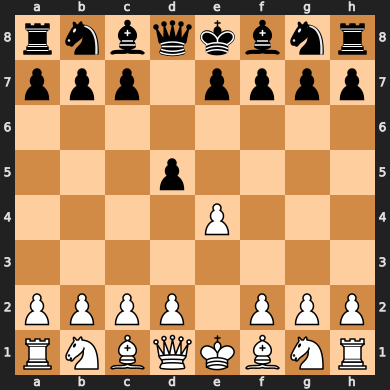

In [11]:
print(lines[8])
lines[8].end_board

## Black games

In [12]:
# Load the games
graph = games_graph(black_games, 10)

len(graph.graph.vs["name"])

1638

In [13]:
# Load the evaluations
fen_evals = load_evals_json('eval-black.json')
compute_rating(fen_evals, rating_white)

len(fen_evals)

1638

In [14]:
update_graph_rating(graph, fen_evals)
compute_graph_weights(graph, white_uniform=False)

# Shortest paths from initial to every other position.
sp = graph.graph.get_shortest_paths(graph.start_node, weights=graph.graph.es["weight"])
all_lines = [compute_line(graph, p) for p in sp]
lines = best_lines(all_lines, 0.6)
lines[:10]

[rnbqkb1r/pppppppp/5n2/8/4P3/8/PPPP1PPP/RNBQKBNR w KQkq - 1 2: ['e2e4', 'g8f6'] (prob=0.412639405204461 rating=0.6633333333333333),
 rnbqkb1r/pppppppp/5n2/4P3/8/8/PPPP1PPP/RNBQKBNR b KQkq - 0 2: ['e2e4', 'g8f6', 'e4e5'] (prob=0.07806691449814128 rating=0.655),
 rnbqkb1r/pppppppp/8/3nP3/8/8/PPPP1PPP/RNBQKBNR w KQkq - 1 3: ['e2e4', 'g8f6', 'e4e5', 'f6d5'] (prob=0.06691449814126395 rating=0.6666666666666666),
 r1bqkb1r/pppppppp/2n2n2/8/4P3/2N5/PPPP1PPP/R1BQKBNR w KQkq - 3 3: ['e2e4', 'g8f6', 'b1c3', 'b8c6'] (prob=0.03717472118959108 rating=0.6666666666666666),
 rnbqkb1r/pppppppp/8/3nP3/3P4/8/PPP2PPP/RNBQKBNR b KQkq - 0 3: ['e2e4', 'g8f6', 'e4e5', 'f6d5', 'd2d4'] (prob=0.02361688169691669 rating=0.6466666666666667),
 rnbqkb1r/pppppppp/8/3nP3/2P5/8/PP1P1PPP/RNBQKBNR b KQkq - 0 3: ['e2e4', 'g8f6', 'e4e5', 'f6d5', 'c2c4'] (prob=0.019680734747430574 rating=0.655),
 r1bqkbnr/pppp1ppp/2n5/4p3/3PP3/8/PPP2PPP/RNBQKBNR w KQkq - 1 3: ['e2e4', 'e7e5', 'd2d4', 'b8c6'] (prob=0.018587360594795543 rating

<AxesSubplot:ylabel='Frequency'>

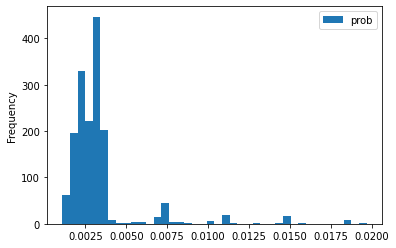

In [15]:
import pandas

data = pandas.Series([
    x.probability
    for x in all_lines
    if x is not None and x.probability < 0.02
])
df = pandas.DataFrame({"prob": data}, columns=["prob"])
df.plot.hist(bins=40)

rnbqkbnr/pppp1p1p/6p1/4p2Q/4P3/8/PPPP1PPP/RNB1KBNR w KQkq - 0 3: ['e2e4', 'e7e5', 'd1h5', 'g7g6'] (prob=0.011152416356877323 rating=1.0)


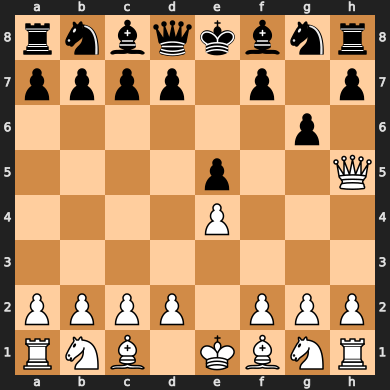

In [16]:
high_adv = [x for x in lines if x.rating > 0.7][:10]
print(high_adv[0])
high_adv[0].end_board

Not good. Moves the Q out early, hoping for a black mistake.

rnbqkb1r/pppppppp/8/4P3/4n3/8/PPPP1PPP/RNBQKBNR w KQkq - 1 3: ['e2e4', 'g8f6', 'e4e5', 'f6e4'] (prob=0.011152416356877325 rating=0.79)


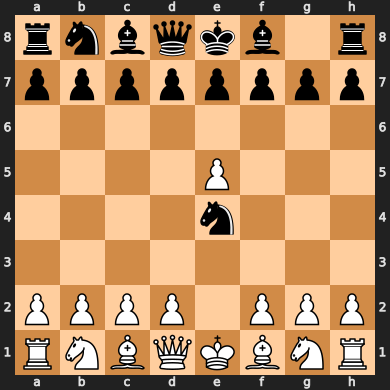

In [17]:
print(high_adv[1])
high_adv[1].end_board

+1.4 but played the wrong move only 3/16 times.

rnbqkbnr/pppp1ppp/8/4p3/3P4/8/PPP1PPPP/RNBQKBNR w KQkq - 0 2: ['d2d4', 'e7e5'] (prob=0.011152416356877323 rating=0.7966666666666666)


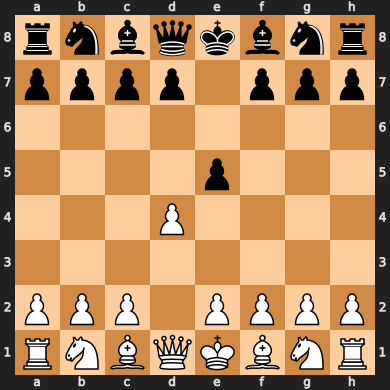

In [18]:
print(high_adv[2])
high_adv[2].end_board

rnbqkbnr/ppp2ppp/8/3pp3/3P4/4P3/PPP2PPP/RNBQKBNR w KQkq - 0 3: ['d2d4', 'd7d5', 'e2e3', 'e7e5'] (prob=0.0037174721189591076 rating=0.71)


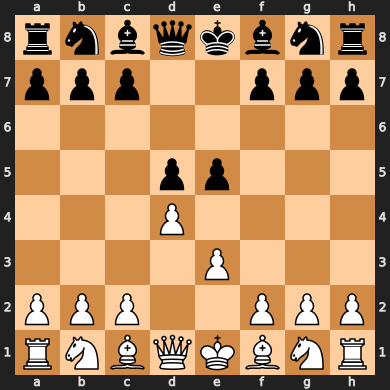

In [19]:
not_e4 = [l for l in lines if l.moves_uci[0] != "e2e4" and l.rating > 0.7]
print(not_e4[1])
not_e4[1].end_board

Interesting position. He seems to often get it wrong. The main last moves are:

* Nc6 (2) +0.8
* e6 (2) +0.1
* c5 +0.3
* a6 +0.2
* e5 +1.5
